In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])

#dataloader
train_path =  r"C:\Dataset\Train_set"
test_path = r"C:\Dataset\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=44, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=22, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

cuda
['L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others']


In [2]:
import torch
import torch.nn as nn
from math import ceil

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 300, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(1, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [3]:
model=EfficientNet("b0", num_classes=23).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

77846 23666


In [4]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [5]:
y_pred = []
y_true = []
train_losses = []
test_accuracies = []
best_accuracy= 0.0
test_accuracy=0.0
train_accuracy=0.0
train_loss=0.0

In [6]:
def train_test(start_epochs, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred):
    #Model training and saving best model

    for epoch in range(start_epochs, num_epochs+1):

        #Evaluation and training on training dataset
        model.train()

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count

        # Evaluation on testing dataset
        model.eval()

        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
        
        train_losses.append(train_loss.item())
        test_accuracies.append(test_accuracy)
        checkpoint = {
                'start_epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_loss': train_loss,
                'train_losses':train_losses,
                'test_accuracies': test_accuracies,
                'y_true': y_true,
                'y_pred': y_pred
        }
        save_ckp(checkpoint, False, checkpoint_path='current_checkpoint_efficientNet_b0.pt', best_model_path='best_checkpoint_efficientNet_b0.model')
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint_efficientNet_b0.model')
            best_accuracy=test_accuracy
            checkpoint['best_accuracy']=best_accuracy
            save_ckp(checkpoint, True, checkpoint_path='current_checkpoint_efficientNet_b0.pt', best_model_path='best_checkpoint_efficientNet_b0.model')

In [7]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    train_loss = checkpoint['train_loss']    
    train_losses = checkpoint['train_losses']    
    test_accuracies = checkpoint['test_accuracies']   
    start_epoch = checkpoint['start_epoch']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    return model, optimizer,start_epoch,best_accuracy, train_accuracy,test_accuracy,train_loss.item(),train_losses,test_accuracies,y_true,y_pred

In [8]:
def conf_matrix(y_true,y_pred):
     # constant for classes
    classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

In [9]:
def learn_curve_train_losses(train_losses):
    plt.plot(train_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train'])
    plt.title('Train Losses Per Epoch')

    plt.show()
    
def learn_curve_test_accuracies(test_accuracies):
    plt.plot(test_accuracies,'-r')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.legend(['Test Accuracy'])
    plt.title('Test Accuracy Per Epoch')
    plt.show()


In [ ]:
num_epochs = 25

import os.path

if os.path.isfile("current_checkpoint_effecientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)


Epoch: 1 Train Loss: tensor(2.4646) Train Accuracy: 0.1903116409320967 Test Accuracy: 0.22796416800473251
Epoch: 2 Train Loss: tensor(1.9681) Train Accuracy: 0.3290366918228416 Test Accuracy: 0.41376776659207326
Epoch: 3 Train Loss: tensor(1.5022) Train Accuracy: 0.4952255611937906 Test Accuracy: 0.49938366296655934
Epoch: 4 Train Loss: tensor(1.2258) Train Accuracy: 0.5884502122852965 Test Accuracy: 0.5797557417249626
Epoch: 5 Train Loss: tensor(1.0517) Train Accuracy: 0.6453843286772896 Test Accuracy: 0.5970413147866865
Epoch: 6 Train Loss: tensor(0.9298) Train Accuracy: 0.6893564908194213 Test Accuracy: 0.604056327276041
Epoch: 7 Train Loss: tensor(0.8380) Train Accuracy: 0.7205982241411354 Test Accuracy: 0.6479592688383029
Epoch: 8 Train Loss: tensor(0.7616) Train Accuracy: 0.7456609279632113 Test Accuracy: 0.6440736904955986
Epoch: 9 Train Loss: tensor(0.6904) Train Accuracy: 0.7708134735365717 Test Accuracy: 0.6671868534475828


In [ ]:
num_epochs = 25

import os.path

if os.path.isfile("current_checkpoint_effecientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)


Epoch: 1 Train Loss: tensor(2.4899) Train Accuracy: 0.18242427356575802 Test Accuracy: 0.22940082819234345
Epoch: 2 Train Loss: tensor(2.0185) Train Accuracy: 0.30804643044310004 Test Accuracy: 0.3672876447573816


In [ ]:
num_epochs = 160

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 3 Train Loss: tensor(1.6238) Train Accuracy: 0.4544910213296822 Test Accuracy: 0.48387421987850743
Epoch: 4 Train Loss: tensor(1.3267) Train Accuracy: 0.5565662267942004 Test Accuracy: 0.4131870140378551


In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 5 Train Loss: tensor(1.1378) Train Accuracy: 0.6187929574573747 Test Accuracy: 0.5675404879157456
Epoch: 6 Train Loss: tensor(1.0060) Train Accuracy: 0.6648847569940326 Test Accuracy: 0.6060833068743309
Epoch: 7 Train Loss: tensor(0.8966) Train Accuracy: 0.7006611114862291 Test Accuracy: 0.6204937920775321
Epoch: 8 Train Loss: tensor(0.8120) Train Accuracy: 0.7294748691148099 Test Accuracy: 0.6547207172226857
Epoch: 9 Train Loss: tensor(0.7426) Train Accuracy: 0.7504525534371594 Test Accuracy: 0.6515108054051053
Epoch: 10 Train Loss: tensor(0.6770) Train Accuracy: 0.7781228380720068 Test Accuracy: 0.6587362254206628
Epoch: 11 Train Loss: tensor(0.6148) Train Accuracy: 0.7967111749202023 Test Accuracy: 0.66790580310257
Epoch: 12 Train Loss: tensor(0.5769) Train Accuracy: 0.8095958265187025 Test Accuracy: 0.6774557553369012
Epoch: 13 Train Loss: tensor(0.5341) Train Accuracy: 0.8250881175118377 Test Accuracy: 0.6586528122942338
Epoch: 14 Train Loss: tensor(0.5014) Train Accuracy: 

In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 31 Train Loss: tensor(0.2355) Train Accuracy: 0.9217932813046604 Test Accuracy: 0.7570252300558693


In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 32 Train Loss: tensor(0.2290) Train Accuracy: 0.9237458802415192 Test Accuracy: 0.751236247157528


In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 33 Train Loss: tensor(0.2198) Train Accuracy: 0.9273812880029833 Test Accuracy: 0.7612503691476024


In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 34 Train Loss: tensor(0.2182) Train Accuracy: 0.9278052485842304 Test Accuracy: 0.7645889144920625
Epoch: 35 Train Loss: tensor(0.2094) Train Accuracy: 0.930361583193081 Test Accuracy: 0.749546378302818


In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 38 Train Loss: tensor(0.1994) Train Accuracy: 0.9344980241463575 Test Accuracy: 0.7425750472464334
Epoch: 39 Train Loss: tensor(0.1944) Train Accuracy: 0.9366561480104841 Test Accuracy: 0.7817012834888551
Epoch: 40 Train Loss: tensor(0.1958) Train Accuracy: 0.9353202047137684 Test Accuracy: 0.7669982971893641
Epoch: 41 Train Loss: tensor(0.1873) Train Accuracy: 0.9381848177196607 Test Accuracy: 0.7639975914094984
Epoch: 42 Train Loss: tensor(0.1850) Train Accuracy: 0.9399704311694593 Test Accuracy: 0.7590536633817041
Epoch: 43 Train Loss: tensor(0.1776) Train Accuracy: 0.9425781667706904 Test Accuracy: 0.7733355469307606
Epoch: 44 Train Loss: tensor(0.1778) Train Accuracy: 0.9419615982602416 Test Accuracy: 0.7666599060063776
Epoch: 45 Train Loss: tensor(0.1730) Train Accuracy: 0.9437471669912167 Test Accuracy: 0.7632369923056709
Epoch: 46 Train Loss: tensor(0.1727) Train Accuracy: 0.943670114677273 Test Accuracy: 0.7873220331696233
Epoch: 47 Train Loss: tensor(0.1708) Train Accu

In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 51 Train Loss: tensor(0.1605) Train Accuracy: 0.9473312285458194 Test Accuracy: 0.7643339900605904
Epoch: 52 Train Loss: tensor(0.1591) Train Accuracy: 0.9479478371557762 Test Accuracy: 0.8011393701508519
Epoch: 53 Train Loss: tensor(0.1568) Train Accuracy: 0.9491296655940851 Test Accuracy: 0.796577416520331
Epoch: 54 Train Loss: tensor(0.1521) Train Accuracy: 0.9498490497863165 Test Accuracy: 0.8002111289367244
Epoch: 55 Train Loss: tensor(0.1565) Train Accuracy: 0.9484745503821621 Test Accuracy: 0.7947181699961522
Epoch: 56 Train Loss: tensor(0.1520) Train Accuracy: 0.9499646542474937 Test Accuracy: 0.788886787719513
Epoch: 57 Train Loss: tensor(0.1489) Train Accuracy: 0.951557561912677 Test Accuracy: 0.6673619913288142
Epoch: 58 Train Loss: tensor(0.1486) Train Accuracy: 0.9512492813704225 Test Accuracy: 0.7961492166817936
Epoch: 59 Train Loss: tensor(0.1443) Train Accuracy: 0.9527008613067 Test Accuracy: 0.796027894414632
Epoch: 60 Train Loss: tensor(0.1456) Train Accuracy: 

In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 64 Train Loss: tensor(0.1367) Train Accuracy: 0.9560536845666564 Test Accuracy: 0.8161827526867627
Epoch: 65 Train Loss: tensor(0.1384) Train Accuracy: 0.955424248563633 Test Accuracy: 0.785084770673231
Epoch: 66 Train Loss: tensor(0.1388) Train Accuracy: 0.954653487966608 Test Accuracy: 0.8118729436647796
Epoch: 67 Train Loss: tensor(0.1341) Train Accuracy: 0.9559766032100295 Test Accuracy: 0.8118318208798979
Epoch: 68 Train Loss: tensor(0.1347) Train Accuracy: 0.9561050789584976 Test Accuracy: 0.7966623777495513
Epoch: 69 Train Loss: tensor(0.1323) Train Accuracy: 0.9576080480060497 Test Accuracy: 0.7650974673530698
Epoch: 70 Train Loss: tensor(0.1302) Train Accuracy: 0.9580448270694448 Test Accuracy: 0.8184215793740959
Epoch: 71 Train Loss: tensor(0.1315) Train Accuracy: 0.9572740801688856 Test Accuracy: 0.7966204014864943
Epoch: 72 Train Loss: tensor(0.1297) Train Accuracy: 0.9580062851537673 Test Accuracy: 0.8255217028818342
Epoch: 73 Train Loss: tensor(0.1290) Train Accura

In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 78 Train Loss: tensor(0.1236) Train Accuracy: 0.9598689936570293 Test Accuracy: 0.8184655142377529
Epoch: 79 Train Loss: tensor(0.1242) Train Accuracy: 0.9602543466458605 Test Accuracy: 0.8334665116840294
Epoch: 80 Train Loss: tensor(0.1212) Train Accuracy: 0.9607810324788254 Test Accuracy: 0.8293261838296158
Epoch: 81 Train Loss: tensor(0.1217) Train Accuracy: 0.9599075197316815 Test Accuracy: 0.8272555280226414
Epoch: 82 Train Loss: tensor(0.1232) Train Accuracy: 0.9599075085106458 Test Accuracy: 0.7995786045604675
Epoch: 83 Train Loss: tensor(0.1157) Train Accuracy: 0.9631061314326813 Test Accuracy: 0.7976337183556393
Epoch: 84 Train Loss: tensor(0.1171) Train Accuracy: 0.9619500437547392 Test Accuracy: 0.8173243316875838
Epoch: 85 Train Loss: tensor(0.1204) Train Accuracy: 0.9611278928916548 Test Accuracy: 0.8196069181243847
Epoch: 86 Train Loss: tensor(0.1169) Train Accuracy: 0.9631446847351552 Test Accuracy: 0.8232409197548435
Epoch: 87 Train Loss: tensor(0.1153) Train Acc

In [ ]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 89 Train Loss: tensor(0.1165) Train Accuracy: 0.9614618904320196 Test Accuracy: 0.8249318277586615


In [10]:
num_epochs = 100

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 90 Train Loss: tensor(0.1171) Train Accuracy: 0.9627079292692037 Test Accuracy: 0.8199030225567379
Epoch: 91 Train Loss: tensor(0.1148) Train Accuracy: 0.9628620957779368 Test Accuracy: 0.8256494508164691
Epoch: 92 Train Loss: tensor(0.1127) Train Accuracy: 0.9639539971494461 Test Accuracy: 0.8316921173603827
Epoch: 93 Train Loss: tensor(0.1098) Train Accuracy: 0.9648275306887593 Test Accuracy: 0.8212132042642339
Epoch: 94 Train Loss: tensor(0.1134) Train Accuracy: 0.9633759580136513 Test Accuracy: 0.8196493371589734
Epoch: 95 Train Loss: tensor(0.1083) Train Accuracy: 0.9653798958964882 Test Accuracy: 0.8305087319081027
Epoch: 96 Train Loss: tensor(0.1122) Train Accuracy: 0.9645192480011292 Test Accuracy: 0.7847895930335465
Epoch: 97 Train Loss: tensor(0.1129) Train Accuracy: 0.9646862333228168 Test Accuracy: 0.8410286820583551
Epoch: 98 Train Loss: tensor(0.1096) Train Accuracy: 0.9644550097144788 Test Accuracy: 0.7953114606896838
Epoch: 99 Train Loss: tensor(0.1117) Train Acc

In [ ]:
num_epochs = 150

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 101 Train Loss: tensor(0.1098) Train Accuracy: 0.9649303090765923 Test Accuracy: 0.827678603601229
Epoch: 102 Train Loss: tensor(0.1096) Train Accuracy: 0.9650202313581825 Test Accuracy: 0.8493969271783826
Epoch: 103 Train Loss: tensor(0.1056) Train Accuracy: 0.9651101536396391 Test Accuracy: 0.8188899432488456
Epoch: 104 Train Loss: tensor(0.1054) Train Accuracy: 0.9658038320550014 Test Accuracy: 0.8422132548780212
Epoch: 105 Train Loss: tensor(0.1035) Train Accuracy: 0.9677050304939502 Test Accuracy: 0.8258194123744984
Epoch: 106 Train Loss: tensor(0.1078) Train Accuracy: 0.96495603762596 Test Accuracy: 0.8250158801408085
Epoch: 107 Train Loss: tensor(0.1060) Train Accuracy: 0.966523199085857 Test Accuracy: 0.8450023246801378
Epoch: 108 Train Loss: tensor(0.1060) Train Accuracy: 0.9658937713331331 Test Accuracy: 0.8473271783286014
Epoch: 109 Train Loss: tensor(0.0994) Train Accuracy: 0.968514321786236 Test Accuracy: 0.8471160030076198
Epoch: 110 Train Loss: tensor(0.1071) Trai

In [ ]:
num_epochs = 150

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 115 Train Loss: tensor(0.0995) Train Accuracy: 0.9672682930151566 Test Accuracy: 0.8329595016189209
Epoch: 116 Train Loss: tensor(0.1007) Train Accuracy: 0.9679105833092646 Test Accuracy: 0.8385376894913217
Epoch: 117 Train Loss: tensor(0.1010) Train Accuracy: 0.9675637529299297 Test Accuracy: 0.8494818954487235
Epoch: 118 Train Loss: tensor(0.1021) Train Accuracy: 0.9673710603467478 Test Accuracy: 0.8599192716088672
Epoch: 119 Train Loss: tensor(0.1005) Train Accuracy: 0.9676665130008008 Test Accuracy: 0.8502011290151106
Epoch: 120 Train Loss: tensor(0.1005) Train Accuracy: 0.9674866745434961 Test Accuracy: 0.8413272289837326


In [ ]:
num_epochs = 150

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 121 Train Loss: tensor(0.0992) Train Accuracy: 0.968193195368735 Test Accuracy: 0.832157581645778
Epoch: 122 Train Loss: tensor(0.1011) Train Accuracy: 0.9676151400610868 Test Accuracy: 0.8434392021288618
Epoch: 123 Train Loss: tensor(0.0961) Train Accuracy: 0.9691951752837662 Test Accuracy: 0.8514680739965406
Epoch: 124 Train Loss: tensor(0.0992) Train Accuracy: 0.9680776044392169 Test Accuracy: 0.8548910448776302
Epoch: 125 Train Loss: tensor(0.0973) Train Accuracy: 0.9693236399764207 Test Accuracy: 0.8472853414622191
Epoch: 126 Train Loss: tensor(0.0983) Train Accuracy: 0.9690025091031007 Test Accuracy: 0.8311859750418941
Epoch: 127 Train Loss: tensor(0.0953) Train Accuracy: 0.9695291858606622 Test Accuracy: 0.8411996613696883
Epoch: 128 Train Loss: tensor(0.0969) Train Accuracy: 0.968912590617191 Test Accuracy: 0.8490172061041734
Epoch: 129 Train Loss: tensor(0.0987) Train Accuracy: 0.9683473641881486 Test Accuracy: 0.8718773352998439
Epoch: 130 Train Loss: tensor(0.0943) Tr

In [ ]:
num_epochs = 150

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 136 Train Loss: tensor(0.0911) Train Accuracy: 0.9713789900727079 Test Accuracy: 0.8647782955864018
Epoch: 137 Train Loss: tensor(0.0979) Train Accuracy: 0.9684373169975345 Test Accuracy: 0.8708216334951233
Epoch: 138 Train Loss: tensor(0.0902) Train Accuracy: 0.9714689057538859 Test Accuracy: 0.8671879836741949
Epoch: 139 Train Loss: tensor(0.0914) Train Accuracy: 0.9706981921859281 Test Accuracy: 0.7965379526740335
Epoch: 140 Train Loss: tensor(0.0919) Train Accuracy: 0.9703770354057009 Test Accuracy: 0.8635931943696726
Epoch: 141 Train Loss: tensor(0.0921) Train Accuracy: 0.9707110240350874 Test Accuracy: 0.8559056702947001
Epoch: 142 Train Loss: tensor(0.0926) Train Accuracy: 0.9709550999540637 Test Accuracy: 0.8732297771347205
Epoch: 143 Train Loss: tensor(0.0918) Train Accuracy: 0.9708394902127271 Test Accuracy: 0.8736530562738585
Epoch: 144 Train Loss: tensor(0.0939) Train Accuracy: 0.9711220979817873 Test Accuracy: 0.8583146139210798
Epoch: 145 Train Loss: tensor(0.0926)

In [10]:
num_epochs = 160

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 146 Train Loss: tensor(0.0923) Train Accuracy: 0.9705311898683135 Test Accuracy: 0.8293269820016687
Epoch: 147 Train Loss: tensor(0.0904) Train Accuracy: 0.971160631646968 Test Accuracy: 0.8593268540092116
Epoch: 148 Train Loss: tensor(0.0906) Train Accuracy: 0.9714432489868671 Test Accuracy: 0.862708498557171
Epoch: 149 Train Loss: tensor(0.0903) Train Accuracy: 0.9712377186143024 Test Accuracy: 0.8516379070607013
Epoch: 150 Train Loss: tensor(0.0901) Train Accuracy: 0.9722396942388642 Test Accuracy: 0.8671449183599704
Epoch: 151 Train Loss: tensor(0.0922) Train Accuracy: 0.971057886592686 Test Accuracy: 0.8560748392173735
Epoch: 152 Train Loss: tensor(0.0880) Train Accuracy: 0.9719699285497854 Test Accuracy: 0.8591167106751973
Epoch: 153 Train Loss: tensor(0.0879) Train Accuracy: 0.9722268577695521 Test Accuracy: 0.8413276057090626
Epoch: 154 Train Loss: tensor(0.0882) Train Accuracy: 0.9716359508113167 Test Accuracy: 0.8763982644978328
Epoch: 155 Train Loss: tensor(0.0901) Tr

In [11]:
num_epochs = 163

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 161 Train Loss: tensor(0.0911) Train Accuracy: 0.9709936687680513 Test Accuracy: 0.8679055227968697
Epoch: 162 Train Loss: tensor(0.0854) Train Accuracy: 0.9735628162483464 Test Accuracy: 0.8610609273017323
Epoch: 163 Train Loss: tensor(0.0859) Train Accuracy: 0.9732417023715573 Test Accuracy: 0.87487792871323


In [12]:
num_epochs = 166

import os.path

if os.path.isfile("current_checkpoint_efficientNet_b0.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 164 Train Loss: tensor(0.0878) Train Accuracy: 0.9719185731020523 Test Accuracy: 0.8264123585704687
Epoch: 165 Train Loss: tensor(0.0871) Train Accuracy: 0.9715460257248042 Test Accuracy: 0.8853556330752375
Epoch: 166 Train Loss: tensor(0.0863) Train Accuracy: 0.9728434543332442 Test Accuracy: 0.8799495206470496


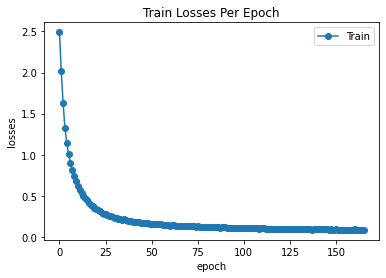

In [14]:
learn_curve_train_losses(train_losses)

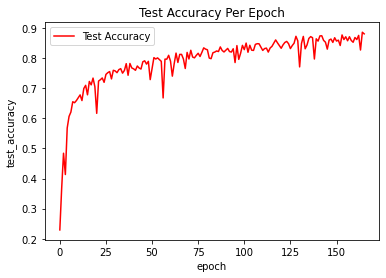

In [15]:
learn_curve_test_accuracies(test_accuracies)

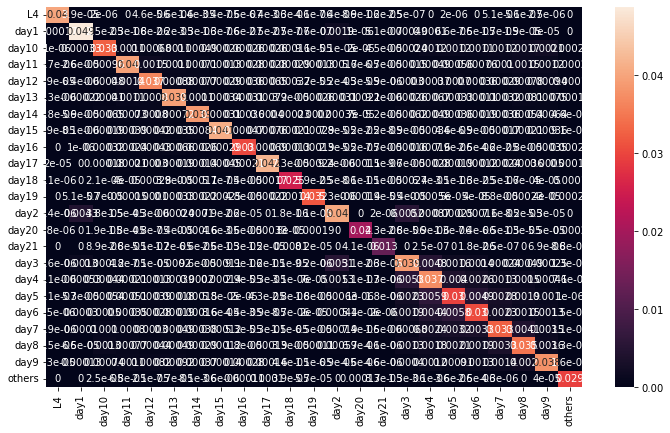

In [16]:
conf_matrix(y_true,y_pred)